In [1]:
%matplotlib inline

# Imports

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import torch
import os
import sys

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from Utilities import util
from Utilities.rand_generators import GridGenerator
from Utilities.normalization import zscore_normalization, zscore_unnormalization
from Networks.mlp import MLP
from Samplers.likelihoods import LikGaussian
from Metrics.sampling import compute_rhat_regression
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper
from Prior_optimization.gpr import GPR
from Prior_optimization.kernels import Exponential
from Prior_optimization.mean_functions import Zero
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Prior_optimization.priors import OptimGaussianPrior, FixedGaussianPrior
from Networks.regression_net_masked import RegressionNetMasked
from Networks.regression_net import RegressionNet
from Networks.mlp_masked import MLPMasked
from Prior_optimization.mean_functions import Zero

In [5]:
os.chdir("..")

In [6]:
mpl.rcParams['figure.dpi'] = 100

In [7]:
OUT_DIR = "./exp/1D_synthetic/tanh_gaussian_new"
FIG_DIR = os.path.join(OUT_DIR, "figures")
util.ensure_dir(OUT_DIR)
util.ensure_dir(FIG_DIR)

In [8]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cuda 

NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of available GPUs: 1


# Utilities

In [9]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", smooth_q=False, ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        if smooth_q:
            lb = moving_average(lb)
            ub = moving_average(ub)
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')

# Generate Data

In [10]:
util.set_seed(1)

N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)
# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

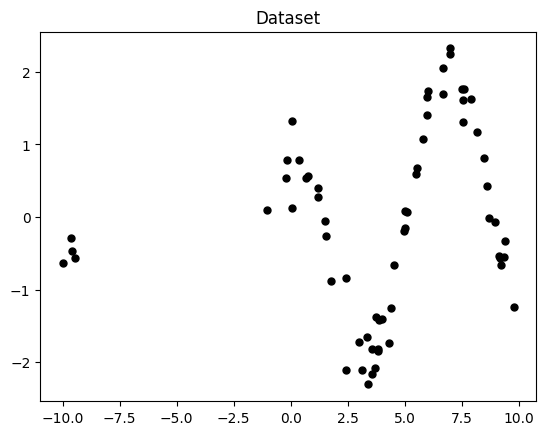

In [11]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset")
plt.show()

In [12]:
Xtest_tensor = torch.from_numpy(Xtest_).to(device)

## Optimize the Prior 

In [13]:
# COnfigurations for the prior optimization
D = 3                                                       # The factorization depth
prior_opt_configurations = {
    "n_data": 512,                                          # The batch size 
    "num_iters": 6000,                                      # The number of iterations of the prior optimization
    "output_dim": 1,                                        # The dimension of the output
    "lambd": (torch.tensor([0.5, 1.5])/D).to(device),       # The regularization parameters for the layers
    "n_samples": 128,                                       # The number of function samples
    "lr": 1e-1,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500,                                 # After how many epochs a checkpoint should be saved
    "shift": 1,                                             # The shift of the schedule for the regularization of the loss
    "scale": 12                                             # The scale of the schedule for the regularization of the loss
}

In [14]:
# Network setup
util.set_seed(1)
width = 50              # Number of units in each hidden layer
depth = 2               # Number of hidden layers
transfer_fn = "tanh"    # Activation function
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)
data_generator = GridGenerator(-8, 8)

In [15]:
# Initialize BNN Priors
opt_bnn_sparse = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
opt_bnn_sparse = opt_bnn_sparse.to(device)

fixed_bnn = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
fixed_bnn = fixed_bnn.to(device)

In [16]:
# GP hyper-parameters
sn2 = 0.1   # noise variance
leng = 0.6  # lengthscale
ampl = 1.0  # amplitude

# Initialize GP Prior
kernel = Exponential(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng], dtype=torch.double),
        variance=torch.tensor([ampl], dtype=torch.double))
kenrel = kernel.to(device)

In [17]:
# Initiialize the Wasserstein optimizer
util.set_seed(1)
mapper = PriorOptimisationMapper(out_dir=OUT_DIR, device=device, kernel = kernel).to(device)
# Start optimizing the prior
p_hist, w_hist = mapper.optimize(opt_bnn_sparse, data_generator,**prior_opt_configurations)
wsr_path = os.path.join(OUT_DIR, "wsr_values.log")
np.savetxt(wsr_path, w_hist, fmt='%.6e')     
pruned_path = os.path.join(OUT_DIR, "pruned_values.log")
np.savetxt(pruned_path, p_hist, fmt='%.6e')     

>>> Iteration #   1: Difference from GP 18334.9827 Number of pruned stochastic weights: 0
>>> Iteration # 100: Difference from GP 17638.4999 Number of pruned stochastic weights: 4
>>> Iteration # 200: Difference from GP 19375.1239 Number of pruned stochastic weights: 4
>>> Iteration # 300: Difference from GP 17198.6939 Number of pruned stochastic weights: 4
>>> Iteration # 400: Difference from GP 18061.3792 Number of pruned stochastic weights: 4
>>> Iteration # 500: Difference from GP 17698.6719 Number of pruned stochastic weights: 5
>>> Iteration # 600: Difference from GP 17788.6936 Number of pruned stochastic weights: 6
>>> Iteration # 700: Difference from GP 18269.4140 Number of pruned stochastic weights: 8
>>> Iteration # 800: Difference from GP 25040.6875 Number of pruned stochastic weights: 8
>>> Iteration # 900: Difference from GP 18285.1962 Number of pruned stochastic weights: 14
>>> Iteration # 1000: Difference from GP 17035.4314 Number of pruned stochastic weights: 16
>>> Ite

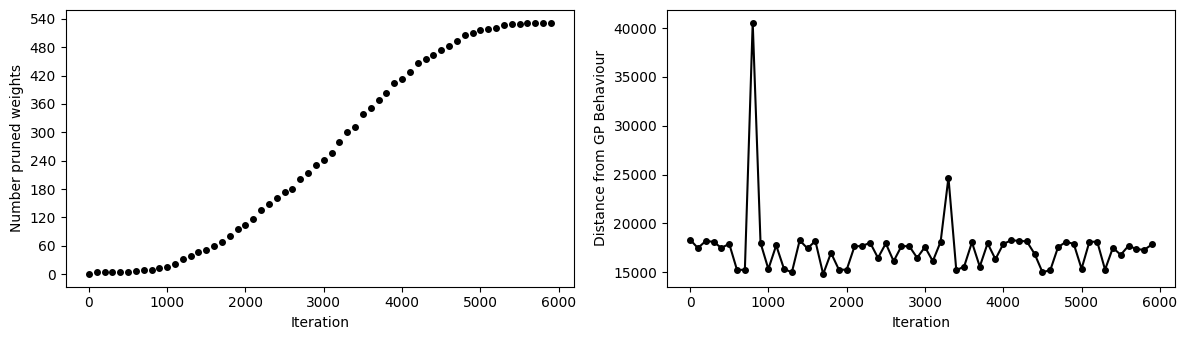

In [18]:
# Visualize progression of the prior optimization
num_iters_sd = prior_opt_configurations["num_iters"]
w_hist = np.loadtxt(wsr_path)
p_hist = np.loadtxt(pruned_path)

indices = np.arange(num_iters_sd)[::100]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, p_hist[indices], "ko", ms=4)
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, w_hist[indices], "-ko", ms=4)
axes[1].set_ylabel("Distance from GP Behaviour")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## Compare Functional Prior

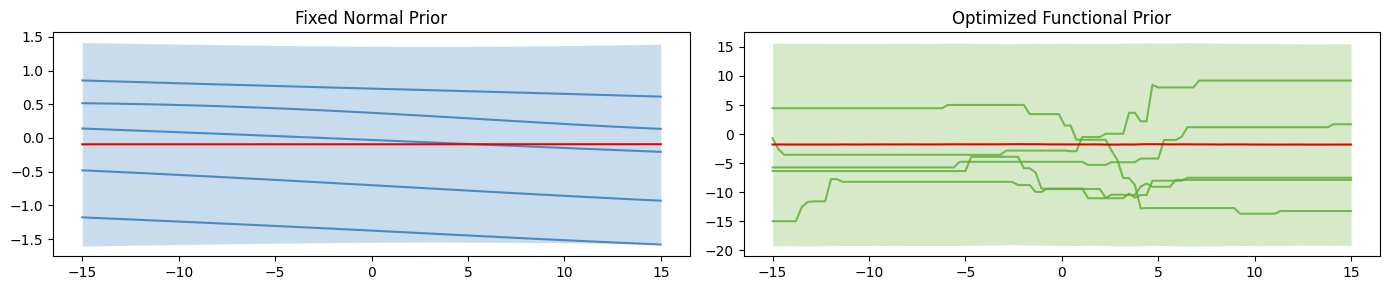

In [19]:
# Draw functions from the priors
n_plot = 4000
util.set_seed(8)

fixed_bnn_samples = fixed_bnn.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
fixed_bnn_samples = zscore_unnormalization(fixed_bnn_samples, y_mean, y_std)

sparse_opt_samples = opt_bnn_sparse.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
sparse_opt_samples = zscore_unnormalization(sparse_opt_samples, y_mean, y_std)

fig, axs = plt.subplots(1,2, figsize=(14, 3))
plot_samples(Xtest, fixed_bnn_samples, ax=axs[0], n_keep=5)
axs[0].set_title('Fixed Normal Prior')
#axs[0].set_ylim([-20, 20])

plot_samples(Xtest, sparse_opt_samples, ax=axs[1], color='xkcd:grass', n_keep=5)
axs[1].set_title('Optimized Functional Prior')
#axs[1].set_ylim([-20, 20])


plt.tight_layout()
plt.show()

# Posterior Inference

In [20]:
# SGHMC Hyper-parameters
sampling_configs = {
    "batch_size": 32,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5,
    "lambd": 0.05
}

# Get the masks for determinstic weights
weights_mask_sd, bias_mask_sd = opt_bnn_sparse.get_det_masks()

## Optimized Prior using SAM

In [21]:
# Load the optimized prior
util.set_seed(1)
ckpt_path_sparse = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(num_iters_sd))
prior_optim_sparse = OptimGaussianPrior(ckpt_path_sparse)

# Setup likelihood and network
likelihood = LikGaussian(sn2)
net_optim_sam = MLPMasked(1, 1, [width]*depth, transfer_fn, weights_mask_sd, bias_mask_sd, D = D, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_optim_sam")
util.ensure_dir(saved_dir)
ps_net_optim_sam = RegressionNetMasked(net_optim_sam, likelihood, prior_optim_sparse, saved_dir, n_gpu=n_gpu)
# Start sampling
ps_net_optim_sam.sample_multi_chains(X, y, sam = True, **sampling_configs)

Chain: 1


W0603 08:58:01.226000 3832864 site-packages/torch/_dynamo/exc.py:304] [0/0] Backend compiler failed with a fake tensor exception at 
W0603 08:58:01.226000 3832864 site-packages/torch/_dynamo/exc.py:304] [0/0]   File "/ibex/user/linharmp/model-selection-partially-stochastic-nn/Networks/mlp_masked.py", line 102, in forward
W0603 08:58:01.226000 3832864 site-packages/torch/_dynamo/exc.py:304] [0/0]     return X
W0603 08:58:01.226000 3832864 site-packages/torch/_dynamo/exc.py:304] [0/0] Adding a graph break.
W0603 08:58:01.772000 3832864 site-packages/torch/_dynamo/exc.py:304] [0/0_1] Backend compiler failed with a fake tensor exception at 
W0603 08:58:01.772000 3832864 site-packages/torch/_dynamo/exc.py:304] [0/0_1]   File "/ibex/user/linharmp/model-selection-partially-stochastic-nn/Networks/mlp_masked.py", line 102, in forward
W0603 08:58:01.772000 3832864 site-packages/torch/_dynamo/exc.py:304] [0/0_1]     return X
W0603 08:58:01.772000 3832864 site-packages/torch/_dynamo/exc.py:304] [0

RuntimeError: self and mat2 must have the same dtype, but got Float and Half

In [ ]:
# Make predictions
_, _, ps_optim_sam_preds = ps_net_optim_sam.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(ps_optim_sam_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
ps_optim_sam_preds = ps_optim_sam_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR, "posterior_optim_sam.npz")
np.savez(posterior_optim_path, bnn_samples=ps_optim_sam_preds)

## Optimized prior without using SAM

In [ ]:
# Setup network
net_optim_no_sam = MLPMasked(1, 1, [width]*depth, transfer_fn, weights_mask_sd, bias_mask_sd, D = D, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_optim_no_sam")
util.ensure_dir(saved_dir)
ps_net_optim_no_sam = RegressionNetMasked(net_optim_no_sam, likelihood, prior_optim_sparse, saved_dir, n_gpu=n_gpu)
# Start sampling
ps_net_optim_no_sam.sample_multi_chains(X, y, sam = False, **sampling_configs)

In [ ]:
# Make predictions
_, _, ps_optim_no_sam_preds = ps_net_optim_no_sam.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(ps_optim_no_sam_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
ps_optim_no_sam_preds = ps_optim_no_sam_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR, "posterior_optim_no_sam.npz")
np.savez(posterior_optim_path, bnn_samples=ps_optim_no_sam_preds)

## Fixed Prior using SAM

In [ ]:
# Load the optimized prior
util.set_seed(1)
prior_fixed = FixedGaussianPrior(std=1.0)

# Setup network
net_fixed_sam = MLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_fixed_sam")
util.ensure_dir(saved_dir)
#net_optim_sparse.change_hook(False)
ps_net_fixed_sam = RegressionNet(net_fixed_sam, likelihood, prior_fixed, saved_dir, n_gpu=n_gpu)
# Start sampling
ps_net_fixed_sam.sample_multi_chains(X, y, sam = True, **sampling_configs)

In [ ]:
# Make predictions
_, _, ps_preds_fixed_sam = ps_net_fixed_sam.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(ps_preds_fixed_sam, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
ps_preds_fixed_sam = ps_preds_fixed_sam.squeeze().T

# Save the predictions
posterior_fixed_path = os.path.join(OUT_DIR, "posterior_fixed_sam.npz")
np.savez(posterior_fixed_path, bnn_samples=ps_preds_fixed_sam)

## Fixed Prior without using SAM

In [ ]:
# Setup likelihood
net_fixed_no_sam = MLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_fixed_no_sam")
util.ensure_dir(saved_dir)
#net_optim_sparse.change_hook(False)
ps_net_fixed_no_sam = RegressionNet(net_fixed_no_sam, likelihood, prior_fixed, saved_dir, n_gpu=n_gpu)
# Start sampling
ps_net_fixed_no_sam.sample_multi_chains(X, y, sam = False, **sampling_configs)

In [ ]:
# Make predictions
_, _, ps_preds_fixed_no_sam = ps_net_fixed_no_sam.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(ps_preds_fixed_no_sam, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
ps_preds_fixed_no_sam = ps_preds_fixed_no_sam.squeeze().T

# Save the predictions
posterior_fixed_path = os.path.join(OUT_DIR, "posterior_fixed_no_sam.npz")
np.savez(posterior_fixed_path, bnn_samples=ps_preds_fixed_no_sam)

# Visualize Predictive Posterior

In [ ]:
util.set_seed(1)

fig, axs = plt.subplots(2,2, figsize=(14, 6))
plot_samples(Xtest, ps_optim_sam_preds, ax = axs[0,0], color='xkcd:yellowish orange', n_keep=16)
axs[0,0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0,0].set_title('Optimized Prior using SAM')
axs[0,0].set_ylim([-4, 4])

plot_samples(Xtest, ps_optim_no_sam_preds, ax = axs[1,0], color='xkcd:yellowish orange', n_keep=16)
axs[1,0].plot(X, y, 'ok', zorder=10, ms=5)
axs[1,0].set_title('Optimized Prior without using SAM')
axs[1,0].set_ylim([-4, 4])

plot_samples(Xtest, ps_preds_fixed_sam, ax=axs[0,1], color='xkcd:grass', n_keep=16)
axs[0,1].plot(X, y, 'ok', zorder=10, ms=5)
axs[0,1].set_title('Fixed Prior using SAM')
axs[0,1].set_ylim([-4, 4])


plot_samples(Xtest, ps_preds_fixed_sam, ax=axs[1,1], color='xkcd:grass', n_keep=16)
axs[1,1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1,1].set_title('Fixed Prior without using SAM')
axs[1,1].set_ylim([-4, 4])


plt.tight_layout()
plt.show()